### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week08_autoencoders/lfw_dataset.py -O lfw_dataset.py
#!pip install Image Pillow==5.1.0 scipy==1.1.0
!pip install Image Pillow==7.2.0 scipy==1.2.0
#!pip3 install -q scipy>=1.2.0
!pip3 install -q imgaug==0.2.5
!pip install imageio==2.9.0

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


#device = torch.device("cpu") # or you print here you favorite gpu card

device = torch.device("cuda:0")

torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

--2021-04-01 07:04:25--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week08_autoencoders/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3060 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.99K  --.-KB/s    in 0s      

2021-04-01 07:04:26 (32.0 MB/s) - ‘lfw_dataset.py’ saved [3060/3060]

     |████████████████████████████████| 2.2MB 14.6MB/s 
     |████████████████████████████████| 26.6MB 109kB/s 
     |████████████████████████████████| 7.8MB 30.6MB/s 
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=8bf275c12450d19eb4fad615407da1b6f221ff72df20336ec6b33a79507b7dae
  Stored in directory: /root/.cache/pip/wheels/87/4c/60/d5904e6

     |████████████████████████████████| 563kB 11.5MB/s 
     |████████████████████████████████| 3.3MB 10.8MB/s 
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
cuda:0


In [2]:
BATCH_SIZE = 32

In [3]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split

X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)

X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [162]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [5]:
img_shape

(3, 38, 38)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


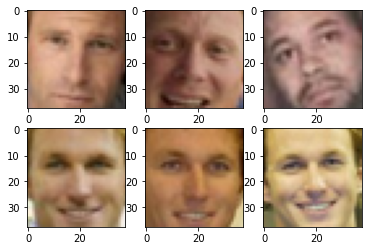

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [7]:
# this class corresponds to view-function and may be used as a reshape layer 

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [8]:
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32):
        super(pca_autoencoder, self).__init__()
        self.enc = nn.Sequential(View(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), View(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        #<Your code: define reconstruction object>
        code = self.enc(batch)
        reconstruction = self.dec(code)
        #

        return torch.mean((reference - reconstruction)**2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [9]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [10]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device = device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [11]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:01, 240.03it/s]
29it [00:00, 285.91it/s]

1, Train loss: 0.14836188665702432, Test loss: 0.031245886428601436


370it [00:01, 274.88it/s]
29it [00:00, 289.42it/s]

2, Train loss: 0.02484196100002656, Test loss: 0.02293461014652019


370it [00:01, 277.08it/s]
29it [00:00, 280.77it/s]

3, Train loss: 0.022433233473131836, Test loss: 0.022293471822550457


370it [00:01, 283.42it/s]
30it [00:00, 289.12it/s]

4, Train loss: 0.022177348918241253, Test loss: 0.02209484481940151


370it [00:01, 280.11it/s]
29it [00:00, 279.70it/s]

5, Train loss: 0.021973165692444733, Test loss: 0.02207075063027259


370it [00:01, 275.75it/s]
29it [00:00, 285.50it/s]

6, Train loss: 0.02172535578920371, Test loss: 0.021761711188686975


370it [00:01, 277.32it/s]
28it [00:00, 279.23it/s]

7, Train loss: 0.021323596208682346, Test loss: 0.021164625752586666


370it [00:01, 281.65it/s]
26it [00:00, 254.62it/s]

8, Train loss: 0.020505810609845725, Test loss: 0.020108240565764827


370it [00:01, 280.93it/s]
29it [00:00, 277.33it/s]

9, Train loss: 0.019317705730008877, Test loss: 0.019807074633770877


370it [00:01, 274.28it/s]
29it [00:00, 287.73it/s]

10, Train loss: 0.017849994417904747, Test loss: 0.017325795492346936


370it [00:01, 281.93it/s]
29it [00:00, 284.78it/s]

11, Train loss: 0.016140759420771558, Test loss: 0.015804369774372037


370it [00:01, 284.47it/s]
29it [00:00, 282.10it/s]

12, Train loss: 0.014640519998562312, Test loss: 0.014154510203255961


370it [00:01, 276.41it/s]
29it [00:00, 285.12it/s]

13, Train loss: 0.013543034068314379, Test loss: 0.012998867599138722


370it [00:01, 277.47it/s]
28it [00:00, 275.25it/s]

14, Train loss: 0.01257633207651839, Test loss: 0.012204340728213622


370it [00:01, 281.43it/s]
30it [00:00, 298.63it/s]

15, Train loss: 0.011738724505832028, Test loss: 0.011344267390706157


370it [00:01, 278.23it/s]
29it [00:00, 282.57it/s]

16, Train loss: 0.01104452497148725, Test loss: 0.010811911877721582


370it [00:01, 279.77it/s]
29it [00:00, 289.91it/s]

17, Train loss: 0.010371289335401001, Test loss: 0.010259852943583083


370it [00:01, 282.67it/s]
29it [00:00, 285.79it/s]

18, Train loss: 0.010028616410904915, Test loss: 0.009942306464134128


370it [00:01, 279.95it/s]
28it [00:00, 272.03it/s]

19, Train loss: 0.00971091365365087, Test loss: 0.009687492958390487


370it [00:01, 280.15it/s]
29it [00:00, 278.99it/s]

20, Train loss: 0.009378783595392104, Test loss: 0.009524597338929474


370it [00:01, 280.27it/s]
29it [00:00, 277.33it/s]

21, Train loss: 0.009125942529760442, Test loss: 0.009392883837482149


370it [00:01, 276.38it/s]
29it [00:00, 289.36it/s]

22, Train loss: 0.008834492332890447, Test loss: 0.01036959267891227


370it [00:01, 282.71it/s]
28it [00:00, 271.16it/s]

23, Train loss: 0.008554910755344355, Test loss: 0.008549971649367352


370it [00:01, 282.23it/s]
28it [00:00, 272.44it/s]

24, Train loss: 0.008291939100221099, Test loss: 0.0085551970272324


370it [00:01, 277.65it/s]
29it [00:00, 287.88it/s]

25, Train loss: 0.008187191517575403, Test loss: 0.008353167349286216


370it [00:01, 280.15it/s]
29it [00:00, 286.57it/s]

26, Train loss: 0.008037033663459548, Test loss: 0.007937650645063138


370it [00:01, 279.82it/s]
29it [00:00, 289.34it/s]

27, Train loss: 0.007853243331839692, Test loss: 0.007982019922190333


370it [00:01, 281.09it/s]
29it [00:00, 282.67it/s]

28, Train loss: 0.007655870237825296, Test loss: 0.0076496894124486944


370it [00:01, 270.74it/s]
27it [00:00, 264.40it/s]

29, Train loss: 0.007515309259034727, Test loss: 0.007769459159970708


370it [00:01, 274.84it/s]
30it [00:00, 295.83it/s]

30, Train loss: 0.0073692480224741225, Test loss: 0.007296093546961379


370it [00:01, 279.60it/s]
30it [00:00, 295.99it/s]

31, Train loss: 0.007306311931719294, Test loss: 0.007761787362700746


370it [00:01, 278.54it/s]
29it [00:00, 286.50it/s]

32, Train loss: 0.007163645102231113, Test loss: 0.0072567258949186335


370it [00:01, 276.63it/s]
28it [00:00, 277.02it/s]

33, Train loss: 0.0070249255972402, Test loss: 0.007033390530418167


370it [00:01, 274.92it/s]
30it [00:00, 290.46it/s]

34, Train loss: 0.0070252835826553105, Test loss: 0.007036286548873674


370it [00:01, 272.31it/s]
29it [00:00, 286.79it/s]

35, Train loss: 0.006935352138714692, Test loss: 0.006916169572503218


370it [00:01, 277.55it/s]
29it [00:00, 287.75it/s]

36, Train loss: 0.006862248479247293, Test loss: 0.006885579244353765


370it [00:01, 279.89it/s]
28it [00:00, 275.44it/s]

37, Train loss: 0.006821461241837697, Test loss: 0.00691348544960967


370it [00:01, 278.34it/s]
28it [00:00, 277.72it/s]

38, Train loss: 0.006763555154216321, Test loss: 0.006870376829502566


370it [00:01, 269.54it/s]
28it [00:00, 277.51it/s]

39, Train loss: 0.006737021197476556, Test loss: 0.006947007678688007


370it [00:01, 279.14it/s]


40, Train loss: 0.006696988869111029, Test loss: 0.006628137712599791


In [12]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.006684950540632955


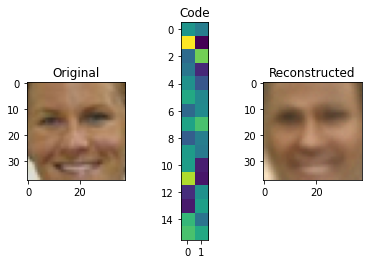

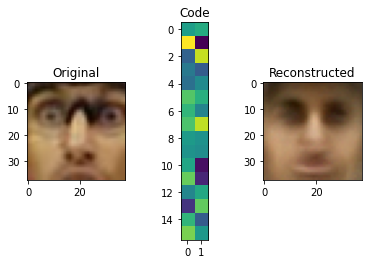

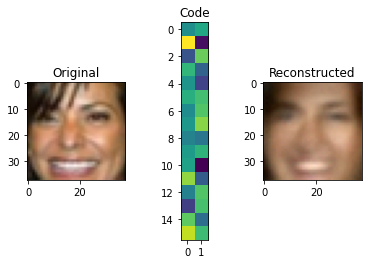

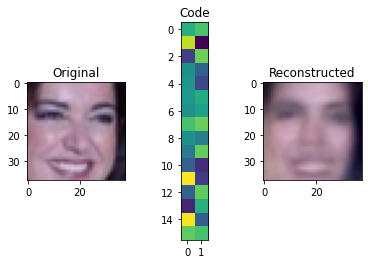

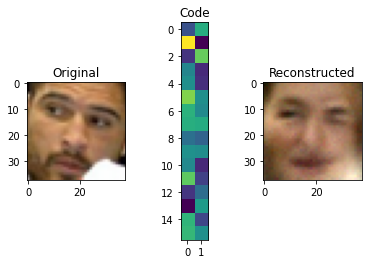

In [13]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)

### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [14]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [15]:
import torch.nn as nn

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [16]:
128 * 9

1152

In [17]:
# class pca_autoencoder_deep(nn.Module):
#     def __init__(self, code_size=32):
#         super(pca_autoencoder_deep, self).__init__()

#         #
        
#         #self.enc = nn.Sequential(View(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
#         #self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), View(-1, img_shape[0], img_shape[1], img_shape[2])) 

#         #
#         encoder = nn.Sequential()

        

#         encoder.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3))
#         encoder.add_module('relu1', nn.ReLU())
#         encoder.add_module('pool1', nn.MaxPool2d(2))

#         encoder.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3))
#         encoder.add_module('relu2', nn.ReLU())
#         encoder.add_module('pool2', nn.MaxPool2d(2))

#         encoder.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3))
#         encoder.add_module('batch1', nn.BatchNorm2d(128))
#         encoder.add_module('relu3', nn.ReLU())
#         encoder.add_module('pool3', nn.MaxPool2d(2))

#         encoder.add_module('flatten', Flatten())
        
#         encoder.add_module('dense1', nn.Linear(128*3*3, 2048))

#         encoder.add_module('batch2', nn.BatchNorm1d(2048))
#         encoder.add_module('relu4', nn.ReLU())
#         encoder.add_module('dropout', nn.Dropout2d(0.1))
        
#         encoder.add_module('dense2', nn.Linear(np.prod(2048), code_size))



#         ########################################################################

#         decoder = nn.Sequential()

#         decoder.add_module('dense1', nn.Linear(code_size, np.prod(img_shape)))
#         decoder.add_module('relu1', nn.ReLU())
       
#         decoder.add_module('dense2', nn.Linear(np.prod(img_shape), 2048))
#         decoder.add_module('relu2', nn.ReLU())
        
#         decoder.add_module('dense3', nn.Linear(2048, 1024))
        
#         decoder.add_module('relu3', nn.ReLU())
        
#         decoder.add_module('dense4', nn.Linear(1024, 512))
#         decoder.add_module('flatten', Flatten())

#         decoder.add_module('dense5', nn.Linear(512, np.prod(img_shape)))
#         decoder.add_module('relu4', nn.ReLU())
      
#         decoder.add_module('view', View(-1, img_shape[0], img_shape[1], img_shape[2]))

#         decoder.add_module('conv2dtrans1', nn.ConvTranspose2d(in_channels=3, out_channels=128, kernel_size=1))
#         decoder.add_module('relu5', nn.ReLU())
#         decoder.add_module('dropout', nn.Dropout2d(0.1))
#         decoder.add_module('conv2dtrans2', nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=1))
#         decoder.add_module('relu6', nn.ReLU())
#         decoder.add_module('conv2dtrans3', nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=1))
#         decoder.add_module('relu7', nn.ReLU())
#         decoder.add_module('conv2dtrans4', nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=1))
        


#         #<Your code: define encoder as per instructions above>
#         self.enc = encoder

#         #<Your code: define decoder as per instructions above>
#         self.dec = decoder
    
#     def batch_loss(self, batch, reference):
#         a = self.enc(batch)
#         reconstruction = self.dec(a)
#         return torch.mean((reference - reconstruction)**2)

In [18]:
np.prod(img_shape)

4332

In [19]:
# class pca_autoencoder_deep(nn.Module):
#     def __init__(self, code_size=32):
#         super(pca_autoencoder_deep, self).__init__()

#         #<Your code: define encoder as per instructions above>
#         self.enc = nn.Sequential(
            
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=9),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             Flatten(),
            
#             nn.Linear(128, 2048),

#             nn.BatchNorm1d(2048),
#             nn.ReLU(),
#             nn.Dropout2d(0.1),

#             nn.Linear(2048, 4096),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
            
#             nn.Linear(4096, 2048),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),

#             nn.Linear(2048, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),

#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),

#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),

#             nn.Linear(256, code_size),
#             nn.Sigmoid()
#         )

#         #<Your code: define decoder as per instructions above>
#         self.dec = nn.Sequential(
#             nn.Linear(code_size, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(1024, 2048),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(2048, np.prod(img_shape)),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             View(-1, img_shape[0], img_shape[1], img_shape[2]),
#             #
            
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=9),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             Flatten(),
            
#             nn.Linear(128, 2048),

#             nn.BatchNorm1d(2048),
#             nn.ReLU(),
#             nn.Dropout2d(0.1),

#             nn.Linear(2048, 4096),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),

#             nn.Linear(4096, np.prod(img_shape)),

#             View(-1, img_shape[0], img_shape[1], img_shape[2])

#         )
    
#     def batch_loss(self, batch, reference):
#         a = self.enc(batch)
#         reconstruction = self.dec(a)
#         return torch.mean((reference - reconstruction)**2)

In [20]:
2**14

16384

In [21]:
class pca_autoencoder_deep(nn.Module):
    def __init__(self, code_size=32):
        super(pca_autoencoder_deep, self).__init__()

        #
        
        self.enc = nn.Sequential(
            View(-1, np.prod(img_shape)), 
            nn.Linear(np.prod(img_shape), 200),
            nn.Linear(200, 1000),
            nn.Linear(1000, np.prod(img_shape)),
            nn.Linear(np.prod(img_shape), code_size))

        self.dec = nn.Sequential(
            nn.Linear(code_size, np.prod(img_shape)),
            nn.Linear(np.prod(img_shape), 200),
            nn.Linear(200, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Linear(1000, np.prod(img_shape)),
            View(-1, img_shape[0], img_shape[1], img_shape[2])) 
        #
        
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [22]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    print(help_tensor.shape)
    model = pca_autoencoder_deep(code_size).double().to(device)
    
    encoder_out = model.enc(help_tensor.to(device))
    

    decoder_out = model.dec(encoder_out)
    print(decoder_out.shape)

    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:]==torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:]==img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

torch.Size([32, 3, 38, 38])
torch.Size([32, 3, 38, 38])
Testing code size 1
torch.Size([32, 3, 38, 38])
torch.Size([32, 3, 38, 38])
Testing code size 8
torch.Size([32, 3, 38, 38])
torch.Size([32, 3, 38, 38])
Testing code size 32
torch.Size([32, 3, 38, 38])
torch.Size([32, 3, 38, 38])
Testing code size 128
torch.Size([32, 3, 38, 38])
torch.Size([32, 3, 38, 38])
Testing code size 512
torch.Size([32, 3, 38, 38])
torch.Size([32, 3, 38, 38])
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [23]:
aenc_deep = pca_autoencoder_deep()
train(aenc_deep, X_train_tensor, X_test_tensor, 50)

370it [00:09, 39.04it/s]
5it [00:00, 41.30it/s]

1, Train loss: 0.0614295912712833, Test loss: 0.029054180494570304


370it [00:09, 39.34it/s]
5it [00:00, 42.49it/s]

2, Train loss: 0.03001655695759004, Test loss: 0.023606633638465227


370it [00:09, 39.17it/s]
5it [00:00, 41.76it/s]

3, Train loss: 0.02397921916043081, Test loss: 0.017688999113485333


370it [00:09, 39.32it/s]
5it [00:00, 42.70it/s]

4, Train loss: 0.02081271946125144, Test loss: 0.018120547816620657


370it [00:09, 39.34it/s]
5it [00:00, 42.21it/s]

5, Train loss: 0.018390303654062804, Test loss: 0.017679728912046104


370it [00:09, 39.24it/s]
5it [00:00, 42.23it/s]

6, Train loss: 0.016927949607819688, Test loss: 0.016886909681633686


370it [00:09, 39.04it/s]
5it [00:00, 42.45it/s]

7, Train loss: 0.015851073133688914, Test loss: 0.014271759093068506


370it [00:09, 39.11it/s]
5it [00:00, 42.36it/s]

8, Train loss: 0.015190990300675347, Test loss: 0.01686849427643237


370it [00:09, 39.07it/s]
5it [00:00, 42.79it/s]

9, Train loss: 0.014361606516440669, Test loss: 0.017098614686133117


370it [00:09, 39.06it/s]
5it [00:00, 42.26it/s]

10, Train loss: 0.01355175490476974, Test loss: 0.01326324653093614


370it [00:09, 38.87it/s]
5it [00:00, 42.03it/s]

11, Train loss: 0.012926831715196, Test loss: 0.013378023044915718


370it [00:09, 38.96it/s]
5it [00:00, 42.41it/s]

12, Train loss: 0.012670478396571132, Test loss: 0.018795111115411482


370it [00:09, 38.94it/s]
5it [00:00, 42.55it/s]

13, Train loss: 0.012618014842080576, Test loss: 0.015115213633500605


370it [00:09, 38.99it/s]
5it [00:00, 41.98it/s]

14, Train loss: 0.012336093522629004, Test loss: 0.023890653012770047


370it [00:09, 38.84it/s]
5it [00:00, 42.51it/s]

15, Train loss: 0.012199411376050406, Test loss: 0.026173691950019517


370it [00:09, 38.99it/s]
5it [00:00, 42.56it/s]

16, Train loss: 0.012076978088894458, Test loss: 0.013597490302484397


370it [00:09, 39.00it/s]
5it [00:00, 42.56it/s]

17, Train loss: 0.011925963806994806, Test loss: 0.012123773626174592


370it [00:09, 38.98it/s]
5it [00:00, 41.63it/s]

18, Train loss: 0.011749936228063855, Test loss: 0.011691542156259735


370it [00:09, 38.84it/s]
5it [00:00, 42.29it/s]

19, Train loss: 0.011671214256023018, Test loss: 0.012194799404581933


370it [00:09, 38.99it/s]
5it [00:00, 41.73it/s]

20, Train loss: 0.011597219777734315, Test loss: 0.012543995462403121


370it [00:09, 38.96it/s]
5it [00:00, 42.61it/s]

21, Train loss: 0.01151813406561998, Test loss: 0.011394074724337249


370it [00:09, 38.98it/s]
5it [00:00, 42.22it/s]

22, Train loss: 0.011528687355800826, Test loss: 0.01267618609151556


370it [00:09, 38.88it/s]
5it [00:00, 42.34it/s]

23, Train loss: 0.011480660836521711, Test loss: 0.013675655255541172


370it [00:09, 38.91it/s]
5it [00:00, 42.44it/s]

24, Train loss: 0.011418607582915106, Test loss: 0.012786645994073365


370it [00:09, 38.89it/s]
5it [00:00, 41.90it/s]

25, Train loss: 0.01130828797221415, Test loss: 0.011994600474697545


370it [00:09, 38.89it/s]
5it [00:00, 41.44it/s]

26, Train loss: 0.011331372437327096, Test loss: 0.011047897561056017


370it [00:09, 38.68it/s]
5it [00:00, 42.01it/s]

27, Train loss: 0.011251658426764727, Test loss: 0.011900718609467887


370it [00:09, 38.85it/s]
5it [00:00, 41.84it/s]

28, Train loss: 0.011197022379430108, Test loss: 0.012128941397312899


370it [00:09, 38.91it/s]
5it [00:00, 41.04it/s]

29, Train loss: 0.01121037649878465, Test loss: 0.01117997579188939


370it [00:09, 38.93it/s]
5it [00:00, 42.07it/s]

30, Train loss: 0.011148926264934049, Test loss: 0.011766053862294698


370it [00:09, 38.77it/s]
5it [00:00, 42.37it/s]

31, Train loss: 0.011148380994812027, Test loss: 0.01138597596618609


370it [00:09, 38.95it/s]
5it [00:00, 42.37it/s]

32, Train loss: 0.011085933342530609, Test loss: 0.013059564594860074


370it [00:09, 38.91it/s]
5it [00:00, 41.81it/s]

33, Train loss: 0.0110211992892632, Test loss: 0.0113035525409904


370it [00:09, 38.94it/s]
5it [00:00, 41.31it/s]

34, Train loss: 0.011073230060625786, Test loss: 0.011180986044803286


370it [00:09, 38.77it/s]
5it [00:00, 42.28it/s]

35, Train loss: 0.010965558930526082, Test loss: 0.011524288648120287


370it [00:09, 38.95it/s]
5it [00:00, 42.30it/s]

36, Train loss: 0.011048708823247672, Test loss: 0.011986827090532417


370it [00:09, 38.98it/s]
5it [00:00, 42.53it/s]

37, Train loss: 0.010987980560671918, Test loss: 0.011492938203345845


370it [00:09, 38.90it/s]
5it [00:00, 41.54it/s]

38, Train loss: 0.01097759295968341, Test loss: 0.011528644274937013


370it [00:09, 38.70it/s]
5it [00:00, 42.13it/s]

39, Train loss: 0.010980642697873284, Test loss: 0.011261106442179149


370it [00:09, 38.94it/s]
5it [00:00, 42.44it/s]

40, Train loss: 0.010956514774585533, Test loss: 0.010698666976006802


370it [00:09, 38.92it/s]
5it [00:00, 42.49it/s]

41, Train loss: 0.010949960875468616, Test loss: 0.012505613538465101


370it [00:09, 38.97it/s]
5it [00:00, 42.05it/s]

42, Train loss: 0.010904897481310929, Test loss: 0.011589137485960273


370it [00:09, 38.81it/s]
5it [00:00, 42.05it/s]

43, Train loss: 0.01092521146971107, Test loss: 0.012011187332011477


370it [00:09, 38.94it/s]
5it [00:00, 42.31it/s]

44, Train loss: 0.010927219018929516, Test loss: 0.010596196076136438


370it [00:09, 38.98it/s]
5it [00:00, 42.11it/s]

45, Train loss: 0.010935234076296655, Test loss: 0.010835740045302503


370it [00:09, 38.99it/s]
5it [00:00, 41.11it/s]

46, Train loss: 0.010887777913730814, Test loss: 0.011268009067885457


370it [00:09, 38.81it/s]
5it [00:00, 42.48it/s]

47, Train loss: 0.010869688659164491, Test loss: 0.011262357327927224


370it [00:09, 38.93it/s]
5it [00:00, 41.06it/s]

48, Train loss: 0.010874546756955783, Test loss: 0.010845796731790844


370it [00:09, 38.84it/s]
5it [00:00, 41.44it/s]

49, Train loss: 0.010878823580364681, Test loss: 0.010867180578431961


370it [00:09, 38.94it/s]


50, Train loss: 0.01081391510166023, Test loss: 0.010842531569203258


Training may take long, it's okay.

Final MSE: 0.011039575003731348


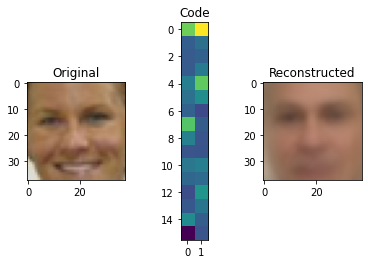

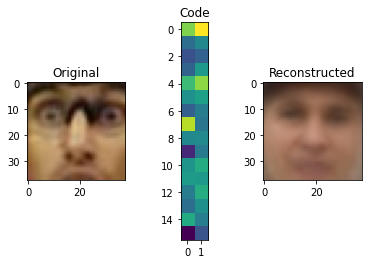

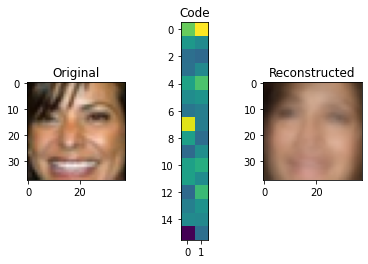

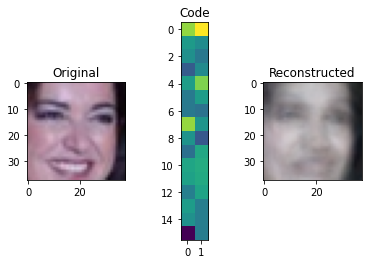

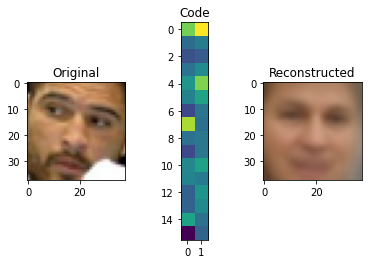

In [24]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

#assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [25]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    #<Your code: define noise>
    
    noise = np.random.normal(0, sigma, X.shape)

    return X + noise
    

In [26]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]),sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]),sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

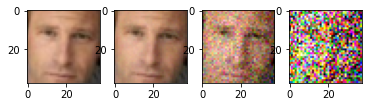

In [27]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [28]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:04, 86.28it/s]
2it [00:00, 19.45it/s]

1, Train loss: 0.1608174980524038, Test loss: 0.03637117683812556


370it [00:04, 85.56it/s]
10it [00:00, 91.61it/s]

2, Train loss: 0.027830511131355044, Test loss: 0.023286496731437144


370it [00:04, 88.47it/s]
9it [00:00, 89.13it/s]

3, Train loss: 0.023696551728383995, Test loss: 0.022637648736861853


370it [00:04, 88.60it/s]
10it [00:00, 90.46it/s]

4, Train loss: 0.023322998979993948, Test loss: 0.022300528096866806


370it [00:04, 88.03it/s]
9it [00:00, 85.51it/s]

5, Train loss: 0.02309266028516037, Test loss: 0.02219379029790635


370it [00:04, 88.76it/s]
10it [00:00, 90.88it/s]

6, Train loss: 0.022826331001610835, Test loss: 0.02202964638557694


370it [00:04, 88.62it/s]
10it [00:00, 92.39it/s]

7, Train loss: 0.022435007444942066, Test loss: 0.02200461432954624


370it [00:04, 88.02it/s]
10it [00:00, 90.47it/s]

8, Train loss: 0.021726240775976572, Test loss: 0.020414079746358692


370it [00:04, 88.76it/s]
9it [00:00, 84.23it/s]

9, Train loss: 0.020559898399270995, Test loss: 0.01906887298263093


370it [00:04, 87.92it/s]
9it [00:00, 86.54it/s]

10, Train loss: 0.018940304469229167, Test loss: 0.01709901749033464


370it [00:04, 88.27it/s]
9it [00:00, 88.36it/s]

11, Train loss: 0.016940728780359095, Test loss: 0.01602130459116638


370it [00:04, 88.78it/s]
9it [00:00, 85.57it/s]

12, Train loss: 0.015229023838526678, Test loss: 0.014980365502770014


370it [00:04, 88.09it/s]
9it [00:00, 85.20it/s]

13, Train loss: 0.013874013965223862, Test loss: 0.013687216778345142


370it [00:04, 87.66it/s]
9it [00:00, 88.61it/s]

14, Train loss: 0.012648447587373811, Test loss: 0.012252267850738388


370it [00:04, 89.25it/s]
9it [00:00, 89.16it/s]

15, Train loss: 0.011677809116581048, Test loss: 0.011136593525518577


370it [00:04, 88.51it/s]
10it [00:00, 89.90it/s]

16, Train loss: 0.010808521362426425, Test loss: 0.010173875570243098


370it [00:04, 87.41it/s]
9it [00:00, 85.91it/s]

17, Train loss: 0.010178013031172427, Test loss: 0.009881709065307028


370it [00:04, 86.91it/s]
9it [00:00, 86.22it/s]

18, Train loss: 0.009702680547117735, Test loss: 0.009453529218714238


370it [00:04, 86.56it/s]
9it [00:00, 89.74it/s]

19, Train loss: 0.009274612098310028, Test loss: 0.0095220932601394


370it [00:04, 88.30it/s]
10it [00:00, 90.34it/s]

20, Train loss: 0.009018741890945989, Test loss: 0.008652128256257387


370it [00:04, 88.52it/s]
10it [00:00, 89.80it/s]

21, Train loss: 0.008707097251417982, Test loss: 0.00980717763071358


370it [00:04, 87.86it/s]
9it [00:00, 85.13it/s]

22, Train loss: 0.008389849966656053, Test loss: 0.008385485424178591


370it [00:04, 88.48it/s]
10it [00:00, 90.98it/s]

23, Train loss: 0.008216303490700384, Test loss: 0.008241986501717806


370it [00:04, 88.20it/s]
9it [00:00, 85.42it/s]

24, Train loss: 0.008027685795478851, Test loss: 0.008299258021738573


370it [00:04, 87.97it/s]
10it [00:00, 90.73it/s]

25, Train loss: 0.007893046717062382, Test loss: 0.00783429262786429


370it [00:04, 88.45it/s]
9it [00:00, 89.59it/s]

26, Train loss: 0.0077113656241195195, Test loss: 0.007610610206333577


370it [00:04, 89.09it/s]
9it [00:00, 84.34it/s]

27, Train loss: 0.007592804247142412, Test loss: 0.00767661464443946


370it [00:04, 88.62it/s]
10it [00:00, 90.72it/s]

28, Train loss: 0.007459607475175244, Test loss: 0.007861749249189687


370it [00:04, 88.68it/s]
9it [00:00, 88.09it/s]

29, Train loss: 0.007374603602340956, Test loss: 0.007377142036471236


370it [00:04, 88.38it/s]
9it [00:00, 88.03it/s]

30, Train loss: 0.00726607320262984, Test loss: 0.0071297360538258425


370it [00:04, 88.60it/s]
9it [00:00, 87.82it/s]

31, Train loss: 0.007153793686097327, Test loss: 0.007145951592253184


370it [00:04, 88.64it/s]
9it [00:00, 86.77it/s]

32, Train loss: 0.007098984563452816, Test loss: 0.007161680714922819


370it [00:04, 88.35it/s]
10it [00:00, 91.48it/s]

33, Train loss: 0.007013718527898346, Test loss: 0.006969490483475909


370it [00:04, 89.07it/s]
9it [00:00, 87.88it/s]

34, Train loss: 0.006986008515967548, Test loss: 0.006894304477876171


370it [00:04, 88.00it/s]
9it [00:00, 82.74it/s]

35, Train loss: 0.006969626664848508, Test loss: 0.006954773650659627


370it [00:04, 88.42it/s]
9it [00:00, 86.27it/s]

36, Train loss: 0.006904164134521119, Test loss: 0.007246693011495532


370it [00:04, 87.66it/s]
9it [00:00, 84.32it/s]

37, Train loss: 0.0068661786676118206, Test loss: 0.0068912181560488025


370it [00:04, 87.75it/s]
10it [00:00, 90.91it/s]

38, Train loss: 0.006803848486901147, Test loss: 0.0067814341145910435


370it [00:04, 87.80it/s]
9it [00:00, 84.87it/s]

39, Train loss: 0.006773032485613057, Test loss: 0.006728895792696484


370it [00:04, 85.86it/s]
9it [00:00, 83.14it/s]

40, Train loss: 0.006791158696552132, Test loss: 0.006737159379561338


370it [00:04, 86.37it/s]
9it [00:00, 88.51it/s]

41, Train loss: 0.006719821425238708, Test loss: 0.006727014247468809


370it [00:04, 88.40it/s]
10it [00:00, 90.34it/s]

42, Train loss: 0.006701177810753844, Test loss: 0.006986129880599593


370it [00:04, 88.48it/s]
9it [00:00, 85.49it/s]

43, Train loss: 0.006677460170935888, Test loss: 0.006729091004487662


370it [00:04, 87.70it/s]
9it [00:00, 85.91it/s]

44, Train loss: 0.0066686108397162845, Test loss: 0.006742317506033361


370it [00:04, 88.46it/s]
9it [00:00, 85.34it/s]

45, Train loss: 0.006657299537209108, Test loss: 0.00693474569823047


370it [00:04, 88.75it/s]
9it [00:00, 87.17it/s]

46, Train loss: 0.006662018233996137, Test loss: 0.0072895457665754825


370it [00:04, 89.16it/s]
9it [00:00, 83.48it/s]

47, Train loss: 0.006662146372246897, Test loss: 0.006699160096956003


370it [00:04, 88.62it/s]
9it [00:00, 89.87it/s]

48, Train loss: 0.006597463003614604, Test loss: 0.006703910232748497


370it [00:04, 88.45it/s]
9it [00:00, 88.95it/s]

49, Train loss: 0.006622168870999878, Test loss: 0.00662231818227356


370it [00:04, 88.99it/s]


50, Train loss: 0.006604419699118655, Test loss: 0.006613540745598558


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.006752018023636071


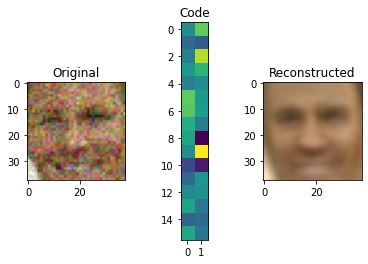

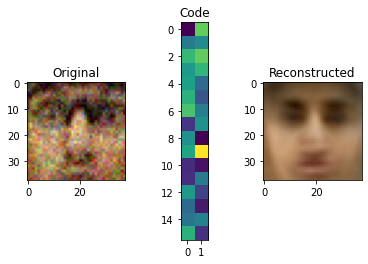

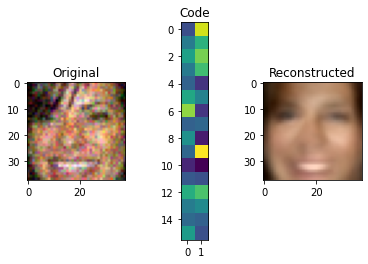

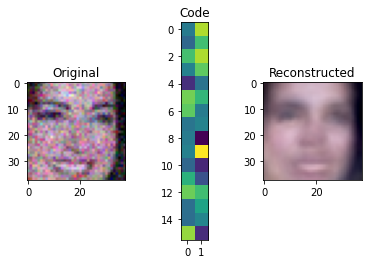

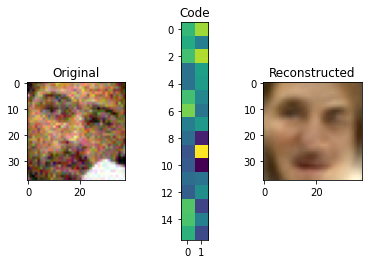

In [29]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [30]:
#encodes batch of images into a codes


#codes = <encode all images in X_train_tensor>

X_train_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    
codes = aenc_deep.enc(X_train_tensor.to(device))


In [31]:
codes.shape

torch.Size([32, 32])

In [33]:
X_train_tensor.shape

torch.Size([32, 3, 38, 38])

In [94]:
X_train_tensor[2]

tensor([[[0.7266, 0.7227, 0.7500,  ..., 0.1875, 0.1914, 0.1602],
         [0.7227, 0.7227, 0.7617,  ..., 0.2148, 0.1797, 0.1602],
         [0.7148, 0.7227, 0.7695,  ..., 0.2266, 0.1797, 0.1641],
         ...,
         [0.5234, 0.6016, 0.6406,  ..., 0.2852, 0.2930, 0.2969],
         [0.4805, 0.5859, 0.6250,  ..., 0.2930, 0.3008, 0.3125],
         [0.4453, 0.5469, 0.5977,  ..., 0.3008, 0.3047, 0.3242]],

        [[0.4453, 0.4688, 0.4922,  ..., 0.1680, 0.1680, 0.1445],
         [0.4453, 0.4609, 0.5000,  ..., 0.1914, 0.1602, 0.1484],
         [0.4414, 0.4531, 0.5000,  ..., 0.2031, 0.1602, 0.1523],
         ...,
         [0.3359, 0.4102, 0.4414,  ..., 0.2812, 0.2852, 0.2773],
         [0.3047, 0.4023, 0.4258,  ..., 0.2891, 0.2930, 0.2891],
         [0.2734, 0.3711, 0.4102,  ..., 0.2969, 0.3008, 0.3008]],

        [[0.3164, 0.3047, 0.3164,  ..., 0.0938, 0.1094, 0.0977],
         [0.3203, 0.3125, 0.3320,  ..., 0.1172, 0.1055, 0.1016],
         [0.3281, 0.3125, 0.3477,  ..., 0.1289, 0.1055, 0.

In [34]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [153]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes.detach().cpu().numpy())

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
from sklearn.neighbors import LSHForest

lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

In [36]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [140]:
X_test_tensor[2][None]

tensor([[[[0.0508, 0.0703, 0.1016,  ..., 0.2852, 0.2305, 0.1406],
          [0.0469, 0.0742, 0.1133,  ..., 0.2617, 0.2070, 0.1523],
          [0.0625, 0.0820, 0.1836,  ..., 0.3047, 0.2031, 0.1367],
          ...,
          [0.1992, 0.1719, 0.0664,  ..., 0.3867, 0.2500, 0.1328],
          [0.1836, 0.1680, 0.0703,  ..., 0.3398, 0.2461, 0.1406],
          [0.1406, 0.1055, 0.0742,  ..., 0.3398, 0.2773, 0.1562]],

         [[0.0352, 0.0508, 0.0703,  ..., 0.1953, 0.1758, 0.1133],
          [0.0352, 0.0508, 0.0742,  ..., 0.1641, 0.1523, 0.1250],
          [0.0430, 0.0508, 0.1289,  ..., 0.2070, 0.1523, 0.1211],
          ...,
          [0.1641, 0.1484, 0.0430,  ..., 0.2734, 0.1758, 0.0938],
          [0.1562, 0.1484, 0.0586,  ..., 0.2227, 0.1680, 0.0938],
          [0.1172, 0.0977, 0.0781,  ..., 0.2227, 0.1875, 0.0977]],

         [[0.0039, 0.0195, 0.0391,  ..., 0.0781, 0.0859, 0.0430],
          [0.0078, 0.0195, 0.0391,  ..., 0.0547, 0.0625, 0.0586],
          [0.0273, 0.0234, 0.0859,  ..., 0

In [197]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    code = aenc_deep.enc(image[None].to(dev))
    
    (distances,),(idx,) = nei_clf.kneighbors(code.detach().cpu().numpy(),n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [203]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

In [206]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

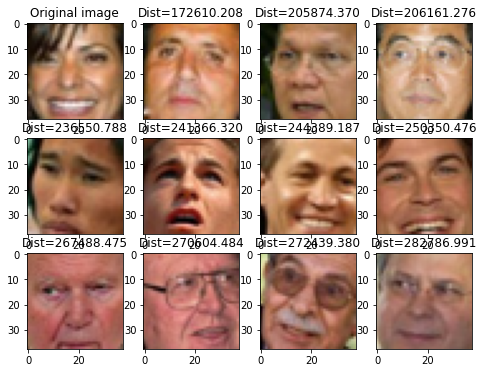

In [208]:
#smiles


Xtesttensor1 = next(iter(DataLoader(X_test_tensor[2], batch_size=BATCH_SIZE)))


show_similar(Xtesttensor1)

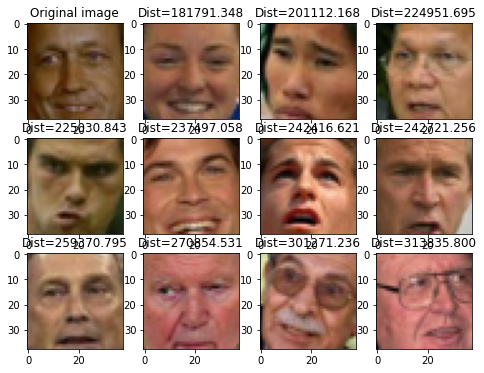

In [209]:
#ethnicity
Xtesttensor2 = next(iter(DataLoader(X_test_tensor[500], batch_size=BATCH_SIZE)))
show_similar(Xtesttensor2)

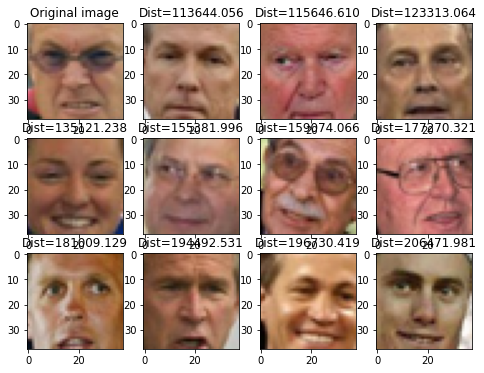

In [210]:
#glasses
Xtesttensor3 = next(iter(DataLoader(X_test_tensor[66], batch_size=BATCH_SIZE)))
show_similar(Xtesttensor3)

## Bonus: cheap image morphing


In [211]:
image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]
a = np.stack([image1,image2])
a.shape

(2, 3, 38, 38)

In [ ]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = aenc.enc(torch.cat((image1,image2), 0).cuda(device))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy())
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.